# VGG16 model

### VGG16 with only 2 categories (Benign and Malign)

## Get packages

In [113]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
import albumentations as A 
import cv2

from skimage.io import imread
from skimage.io import imshow
from skimage.util import crop
from skimage.transform import resize
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.legacy import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras import models
from keras.preprocessing import image

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

## Paths

In [130]:
TRAIN_PATH = 'archive/classification/binary/no_frame/balance/train'
TEST_PATH = 'archive/classification/binary/no_frame/balance/test'
VALID_PATH = 'archive/classification/binary/no_frame/balance/validate'

In [131]:
input_size = (3,224,224)

## Load and Prepare Images

In [132]:
from keras.preprocessing.image import ImageDataGenerator

# # for neaug
# # divisible with 259: 7, 37
# train_batchsize = 7
# # divisible with 51: 3, 17 
# valid_batchsize = 17


# #for aug
# # divisible with 518:  2, 259.
# train_batchsize = 2
# # divisible with 51: 3, 17 
# valid_batchsize = 17


# #for balance
# # divisible with 494: 2, 7, 14, 31, 62, 217
# train_batchsize = 7
# # divisible with 18: 2, 3, 6, 9
# valid_batchsize = 6


# # for neaug non-frame
# # divisible with 253: 11, 23 
# train_batchsize = 23
# # divisible with 50: 2, 5, 10, 25,
# valid_batchsize = 5


# #for aug non-frame
# # divisible with 506: 2, 11, 22, 23, 46, 253,
# train_batchsize = 22
# # divisible with 50: 2, 5, 10, 25,
# valid_batchsize = 5


#for balance non-frame
# divisible with 422: 2, 211.
train_batchsize = 2
# divisible with 16: 2, 4, 8,
valid_batchsize = 4

train_datagen = ImageDataGenerator(
        rescale = 1./255.
)

validation_datagen = ImageDataGenerator(
         rescale = 1./255.
)
                                  

train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,  
        shuffle=True,
         batch_size=train_batchsize,
        target_size=input_size[1:],
        class_mode='categorical')  

validation_generator = validation_datagen.flow_from_directory(
        VALID_PATH,  
        target_size=input_size[1:],
        shuffle=True,
         batch_size=valid_batchsize,
        class_mode='categorical')

Found 422 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Make the model

### From scratch

In [106]:
# Define the model as a sequential sequence of layers
model = Sequential()

# Define convolutional layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Define classification layers
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Print a summary of the model architecture
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                

In [70]:
# Compile the model
model.compile(
              loss=keras.losses.BinaryFocalCrossentropy(),
              optimizer=keras.optimizers.legacy.Adamax(), 
              metrics=['accuracy'])

### Pre-trained

In [133]:
# To show the model arhitecture
from tensorflow.keras.applications.vgg16 import VGG16
# from keras.utils.vis_utils import plot_model
base_model = VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
              layer.trainable = False

In [134]:
model = Sequential()
model.add(base_model)

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_13 (Flatten)        (None, 25088)             0         
                                                                 
 dense_39 (Dense)            (None, 4096)              102764544 
                                                                 
 dropout_26 (Dropout)        (None, 4096)              0         
                                                                 
 dense_40 (Dense)            (None, 4096)              16781312  
                                                                 
 dropout_27 (Dropout)        (None, 4096)              0         
                                                                 
 dense_41 (Dense)            (None, 2)               

In [135]:
model.compile(
    loss=keras.losses.BinaryFocalCrossentropy(),
   optimizer=keras.optimizers.legacy.RMSprop(learning_rate=0.001,decay=1e-3, momentum=0.9),
    metrics = ['accuracy'])

## Train the model

In [136]:
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.Variable) or tf.is_tensor(lr):
            lr = tf.keras.backend.get_value(lr)
        print(f" Epoch {epoch+1}: Learning rate is {lr:.6f}")

In [137]:
# Saving the best result
checkpoiter = tf.keras.callbacks.ModelCheckpoint('model_vgg16_aug_simple.h5', verbose=1, save_best_only=True)
steps = train_generator.samples//train_generator.batch_size
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=4, min_lr=0.00001, verbose=1)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    reduce_lr,
    LearningRateLogger(),
    checkpoiter

]
# Train
results = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    steps_per_epoch = steps,
                    shuffle=True,
                    epochs=25, 
                    callbacks=callbacks,
                 )

Epoch 1/25
211/211 [==============================] - ETA: 0s - loss: 2778.2649 - accuracy: 0.6635 Epoch 1: Learning rate is 0.001000

Epoch 1: val_loss improved from inf to 821.86896, saving model to model_vgg16_aug_simple.h5


/Users/taras_lara/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


211/211 [==============================] - 324s 2s/step - loss: 2778.2649 - accuracy: 0.6635 - val_loss: 821.8690 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/25
211/211 [==============================] - ETA: 0s - loss: 1120.6636 - accuracy: 0.7204 Epoch 2: Learning rate is 0.001000

Epoch 2: val_loss improved from 821.86896 to 494.06958, saving model to model_vgg16_aug_simple.h5
211/211 [==============================] - 320s 2s/step - loss: 1120.6636 - accuracy: 0.7204 - val_loss: 494.0696 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/25
211/211 [==============================] - ETA: 0s - loss: 300.8899 - accuracy: 0.8009 Epoch 3: Learning rate is 0.001000

Epoch 3: val_loss improved from 494.06958 to 274.19025, saving model to model_vgg16_aug_simple.h5
211/211 [==============================] - 305s 1s/step - loss: 300.8899 - accuracy: 0.8009 - val_loss: 274.1902 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/25
211/211 [==============================] - ETA: 0s - loss: 98.2816 - accura

## Results

In [138]:
print('Accuracy Score = ',np.max(results.history['val_accuracy']))
print('Loss Score = ',np.min(results.history['val_loss']))

Accuracy Score =  0.8125
Loss Score =  0.5880537033081055


### During training

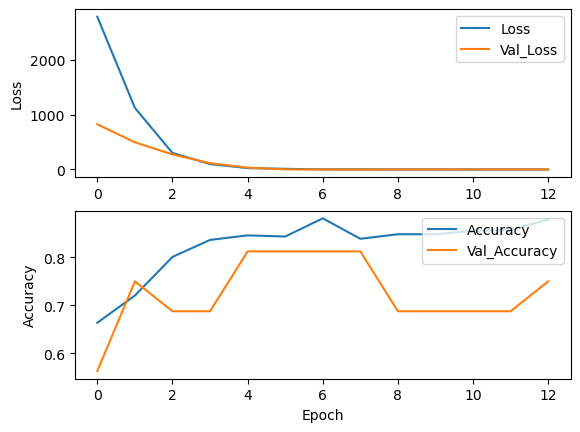

In [140]:
plt.figure()
plt.subplot(211)
loss_train_curve = results.history["loss"]
loss_val_curve = results.history["val_loss"]
plt.plot(loss_train_curve, label = "Loss")
plt.plot(loss_val_curve, label = "Val_Loss")
plt.legend(loc = 'upper right')
plt.ylabel("Loss")


plt.subplot(212)
acc_train_curve = results.history["accuracy"]
acc_val_curve = results.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Accuracy")
plt.plot(acc_val_curve, label = "Val_Accuracy")
plt.legend(loc = 'upper right')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [50]:
train_generator.class_indices

{'benign': 0, 'malign': 1}

## Test the model

In [141]:
# Predict Classes

# divisible with 36: 2, 3, 4, 6, 9, 12, 18
test_batch_size = 3

target_names = list(train_generator.class_indices.keys())
print(target_names)
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=input_size[1:],
#     batch_size=test_batchsize,
    shuffle=True,
class_mode='categorical')

scores = model.evaluate(test_generator,workers=12)
target_names = list(test_generator.class_indices.keys())

['benign', 'malign']
Found 36 images belonging to 2 classes.
2/2 [==============================] - 17s 2s/step - loss: 803.9285 - accuracy: 0.8333


### Make prediction

In [142]:
test_generator.reset()

Y_pred = model.predict(test_generator, verbose=1)

y_pred = np.argmax(Y_pred, axis=-1)
classes = test_generator.classes

print(classes)
print(y_pred)

print(sum(y_pred==classes)/len(test_generator.classes))

2/2 [==============================] - 16s 2s/step
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.8333333333333334


### Confusion Matrix

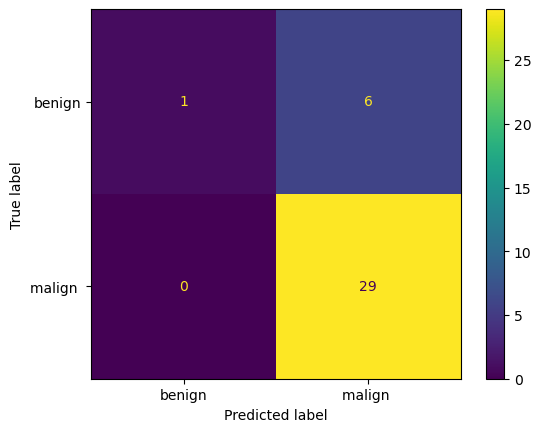

In [143]:
cm = confusion_matrix(classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot()
plt.grid(False)
plt.show()

### Metrics

In [144]:
TN, FP, FN, TP = cm.ravel()

In [145]:
print("True positive=",TP)
print("True Negative=",TN)
print("False positive=",FP)
print("False Negative=",FN)

True positive= 29
True Negative= 1
False positive= 6
False Negative= 0


In [146]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
#F1_SCORE
FSCO=(2*TP) / ((2*TP) +FP + FN) 
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [147]:
print("sensitivity=",round(TPR*100,3),"%")
print("precision=",round(PPV*100,3),"%")
print("Specificity=",round(TNR*100,3),"%")
print("F-score=",round(FSCO*100,3),"%")
print("ACCURACY=",round(ACC*100,3),"%")
print("FNR=",FNR*100,"%")
print("FPR=",FPR*100,"%")
print("NPV=",NPV*100,"%")

sensitivity= 100.0 %
precision= 82.857 %
Specificity= 14.286 %
F-score= 90.625 %
ACCURACY= 83.333 %
FNR= 0.0 %
FPR= 85.71428571428571 %
NPV= 100.0 %
